In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex

In [4]:
import copy
import time

import numpy as np
import scipy
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

random_seed = 456

np.random.seed(random_seed)

In [5]:
N_glyphs_in_alphabet = 40

N_bezier_features = 0
N_line_features = 0
N_ellipse_features = 0
N_multipoint_line_features = 0
multipoint_line_feature_N_points = 3
N_multipoint_bezier_features = 1
multipoint_bezier_feature_N_points = 3

N_glyph_permutations = 20
permutation_strength = 0.08

imgsize = 16

N_glyph_raster_distortions = 10
rotat_distort_max = np.pi / 8
shear_distort_max = np.pi / 8
scale_distort_max = 0.25

blur_factor = 1

N_variations_per_glyph = N_glyph_permutations*N_glyph_raster_distortions

time_start = time.time()
print('Generating glyph alphabet and glyph variations... ', end='')

def makeRandomGlyph(category):
    glyph = lilg.Glyph(
        [lilg.FeatureBezierCurve() for count in range(0,N_bezier_features)]+
        [lilg.FeatureLineSegment() for count in range(0,N_line_features)]+
        [lilg.FeatureEllipse() for count in range(0,N_ellipse_features)]+
        [lilg.FeatureMultiPointLineSegment(multipoint_line_feature_N_points) for count in range(0,N_multipoint_line_features)]+
        [lilg.FeatureMultiPointBezierCurve(multipoint_bezier_feature_N_points) for count in range(0,N_multipoint_bezier_features)]
    )
    glyph.set_category(category)
    glyph.randomize_all_features()
    return glyph

glyphs = []
glyph_categories = list(range(0,N_glyphs_in_alphabet))

for category in glyph_categories:
    glyph = makeRandomGlyph(category)
    glyphs.append(glyph)
    
#starter_glyph = makeRandomGlyph(0)    
#for category in glyph_categories:
#    glyph = starter_glyph.permuted(permutation_strength)
#    glyph.set_category(category)
#    glyphs.append(glyph)

glyph_alphabet = lilg.GlyphList(glyphs)

#glyph_alphabet = lilg.examples.MNISTlike_glyph_alphabet()
#N_glyphs_in_alphabet = len(glyph_alphabet)

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)


time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')


Generating glyph alphabet and glyph variations... done in 11.459 sec (0.286 sec per glyph).


Ground truth glyphs:


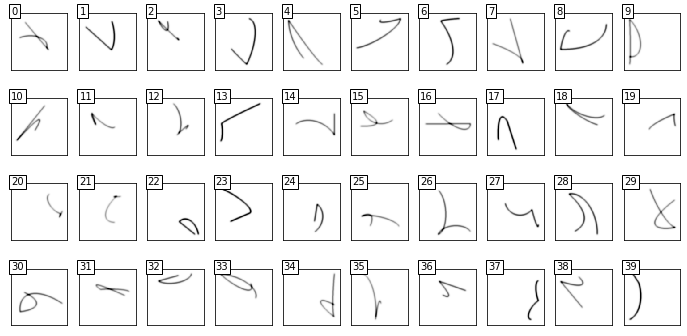

In [6]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_glyphs_in_alphabet, 
    imgsize=128, 
    blur_factor=0.2*16,
    figsize=(12,6)
)
plt.show()

In [7]:
glyph_alphabet.glyphs[17].features[0].values

array([0.20133871, 0.73691833, 0.17707507, 0.15204618, 0.35318227,
       0.39900824, 0.93175207, 0.5431726 , 0.45412693, 0.51393612,
       0.899     , 0.0499203 ])

<function matplotlib.pyplot.show(*args, **kw)>

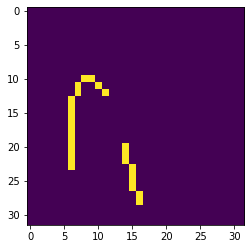

In [9]:
imgsize=32
mode = 'set'
N_points = 3
values = glyph_alphabet.glyphs[17].features[0].values
image = np.zeros((imgsize,imgsize))
imgsize_x, imgsize_y = np.shape(image)[0], np.shape(image)[1]

x1,y1,xc,yc,x2,y2,wc = values[0:7]
x1,xc,x2 = (int(x1*imgsize_x), int(xc*imgsize_x), int(x2*imgsize_x))
y1,yc,y2 = (int(y1*imgsize_y), int(yc*imgsize_y), int(y2*imgsize_y))
cc,rr = skimage.draw.bezier_curve(x1,y1,xc,yc,x2,y2,wc, shape = (imgsize_x,imgsize_y))
if mode=='set':
    image[rr,cc] = 1
else:
    image[rr,cc] = image[rr,cc] + 1

for i in range(0,N_points-2):
    x1, y1 = x2, y2
    xc,yc,x2,y2,wc = values[7+i*5 : 7+(i+1)*5]
    xc,x2 = (int(xc*imgsize_x), int(x2*imgsize_x))
    yc,y2 = (int(yc*imgsize_y), int(y2*imgsize_y))

    cc,rr = skimage.draw.bezier_curve(x1,y1,xc,yc,x2,y2,wc, shape = (imgsize_x,imgsize_y))
    if mode=='set':
        image[rr,cc] = 1
    else:
        image[rr,cc] = image[rr,cc] + 1

plt.imshow(image)
plt.show

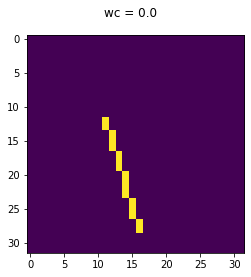

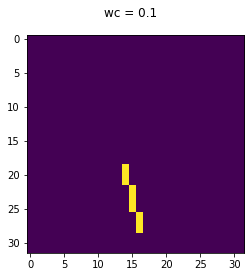

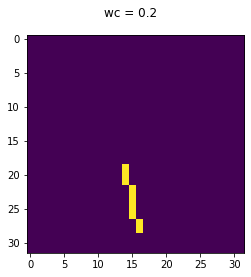

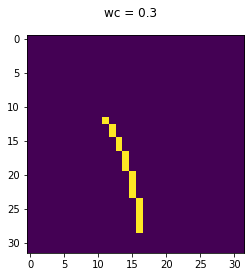

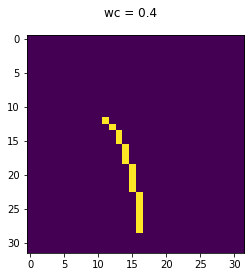

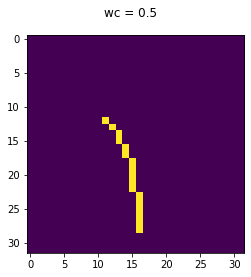

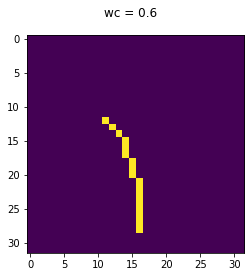

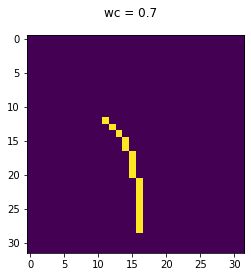

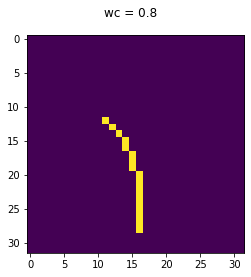

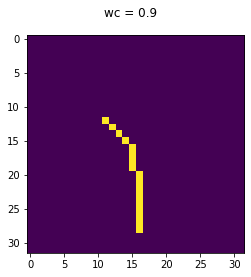

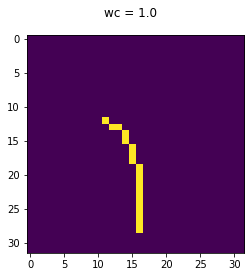

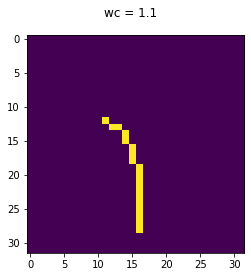

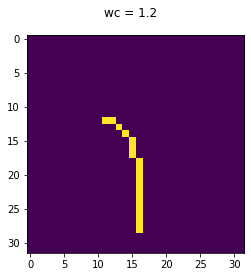

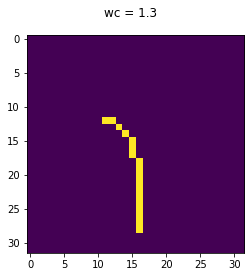

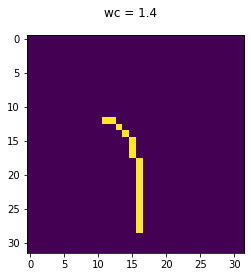

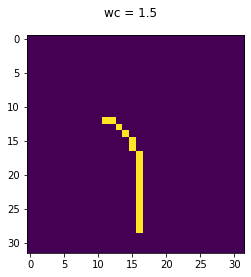

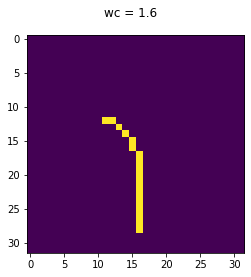

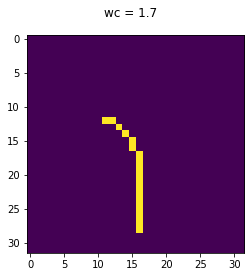

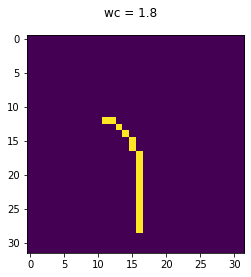

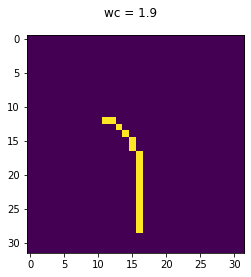

In [10]:
for gwc in range(0,20):
    imgsize=32
    mode = 'set'
    N_points = 3
    image = np.zeros((imgsize,imgsize))
    x1,y1,xc,yc,x2,y2 = [values[i] for i in (4,5,7,8,9,10)]
    wc = gwc /10
    #print(x1,y1,xc,yc,x2,y2,wc)
    x1,xc,x2 = (int(x1*imgsize_x), int(xc*imgsize_x), int(x2*imgsize_x))
    y1,yc,y2 = (int(y1*imgsize_y), int(yc*imgsize_y), int(y2*imgsize_y))
    #print(x1,y1,xc,yc,x2,y2,wc)
    cc,rr = skimage.draw.bezier_curve(x1,y1,xc,yc,x2,y2,wc, shape = (imgsize_x,imgsize_y))
    if mode=='set':
        image[rr,cc] = 1
    else:
        image[rr,cc] = image[rr,cc] + 1
    
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    fig.suptitle('wc = '+str(wc))
    fig.show